In [ ]:
import numpy as np
import pickle
import torch
import torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rootPath = '/content/drive/My Drive/DL_CV_FinalProject/'

videoID1 = 'Kinjal_Fall'
videoID2 = 'Kinjal_Sleep'

## Check for GPU 
gpu_check = torch.cuda.is_available()
print(gpu_check)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
False


In [ ]:
def getMag(pt_diff):
  return np.sqrt(pt_diff[0]**2 + pt_diff[1]**2)

def movAvg(signal,time_v,winSize=5):
    avgSig = []
    print('origSig: ',len(signal))
    print('origTime:',len(time_v))
    for i in range(np.floor(winSize/2).astype(int),len(signal)-np.floor(winSize/2).astype(int)):
        start_id = i-np.floor(winSize/2).astype(int)
        end_id = i+np.ceil(winSize/2).astype(int)
        subSig = [v for v in signal[start_id:end_id] if v != None] 

        if len(subSig) != 0: 
          avgSig.append(np.mean(subSig))
        else:
          avgSig.append(None)
        
    t = time_v[np.floor(winSize/2).astype(int):np.floor(winSize/2).astype(int)+len(avgSig)]

    return t,avgSig

In [ ]:
kpPath1 = rootPath + 'keypoints/' + videoID1 + '.npy'
kpPath2 = rootPath + 'keypoints/' + videoID2 + '.npy'
bodyPoints1 = np.load(kpPath1)
onsetLabelIdx1 = int(np.load(rootPath + 'keypoints/' + videoID1 + 'onsetLabel.npy'))
onsetLabelIdx2 = int(np.load(rootPath + 'keypoints/' + videoID2 + 'onsetLabel.npy'))
print('onset labels:',onsetLabelIdx1,onsetLabelIdx2)
bodyPoints2 = np.load(kpPath2)
numFrames1,_,_ = bodyPoints1.shape
numFrames2,_,_ = bodyPoints2.shape
numFrames1 = int(numFrames1)
numFrames2 = int(numFrames2)
print('Number of Frames:',numFrames1)
print('Number of Frames:',numFrames2)

COCO_PERSON_KEYPOINT_NAMES = [
    "nose",
    "left_eye", "right_eye",
    "left_ear", "right_ear",
    "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow",
    "left_wrist", "right_wrist",
    "left_hip", "right_hip",
    "left_knee", "right_knee",
    "left_ankle", "right_ankle",
]

onset labels: 97 63
Number of Frames: 168
Number of Frames: 163


In [ ]:
def getAvgVel(keypts_allFrames,kp_thresh = 0.09):
  numFrames,_,_ = keypts_allFrames.shape
   
  keypoint_dict = {
      "nose":[],
      "left_eye":[], "right_eye":[],
      "left_ear":[], "right_ear":[],
      "left_shoulder":[], "right_shoulder":[],
      "left_elbow":[], "right_elbow":[],
      "left_wrist":[], "right_wrist":[],
      "left_hip":[], "right_hip":[],
      "left_knee":[], "right_knee":[],
      "left_ankle":[], "right_ankle":[],
  }

  keypointNames_MasterList = list(keypoint_dict)

  keypoint_dict_diff = {
      "nose":[None],
      "left_eye":[None], "right_eye":[None],
      "left_ear":[None], "right_ear":[None],
      "left_shoulder":[None], "right_shoulder":[None],
      "left_elbow":[None], "right_elbow":[None],
      "left_wrist":[None], "right_wrist":[None],
      "left_hip":[None], "right_hip":[None],
      "left_knee":[None], "right_knee":[None],
      "left_ankle":[None], "right_ankle":[None],
  }

  for i,framePts in enumerate(keypts_allFrames):
    for j,kp in enumerate(framePts):
      kpName = keypointNames_MasterList[j]
      if kp[2] > kp_thresh:
        keypoint_dict[kpName].append(kp[:2])
      else:
        keypoint_dict[kpName].append(np.array([None]))

  for kpName in keypoint_dict:
    pts = keypoint_dict[kpName]
    for i in range(1,len(pts)):
      if (pts[i-1].any() != None) and (pts[i].any() != None):
        keypoint_dict_diff[kpName].append(getMag(pts[i]-pts[i-1]))
      else:
        keypoint_dict_diff[kpName].append(None)

  frameAvgDiff = [0]
  for i in range(1,numFrames):
    tmpDiffList_ = []
    for bodyPt in keypoint_dict_diff:
      tmpDiffList_.append(keypoint_dict_diff[bodyPt][i])

    tmpDiffList = np.array([v for v in tmpDiffList_ if v != None])

    if len(tmpDiffList) == 0:
      frameAvgDiff.append(None)
    else:
      diffMean = np.mean(tmpDiffList)
      diffSTD = np.std(tmpDiffList)
      distance_from_mean = abs(tmpDiffList - diffMean)
      max_deviations = 1
      not_outlier = tmpDiffList[distance_from_mean < max_deviations * diffSTD]
      if len(not_outlier) == 0:
        frameAvgDiff.append(None)
      else:
        frameAvgDiff.append(np.mean(not_outlier))

  return frameAvgDiff

def takeManualDeriv(signal,t):
  out_sig = []
  print('sig',len(signal))
  print('time',len(t))
  for i in range(1,len(signal)):
    if (signal[i]==None) or (signal[i-1]==None):
      out_sig.append(None)
    else:
      out_sig.append(signal[i]-signal[i-1])

  print('out sig',len(out_sig))
  print('out time',len(t[1:]))

  return out_sig,t[1:]

def getOnsetPrediction(signal):

  sig = [v for v in signal if v != None]

  avg = np.mean(sig)
  std = np.std(sig)
  thresh = avg+2*std

  for idx,val in enumerate(signal):
    if val != None:
      if val > thresh:
        return idx
  
  return 0

origSig:  168
origTime: 168
origSig:  163
origTime: 163


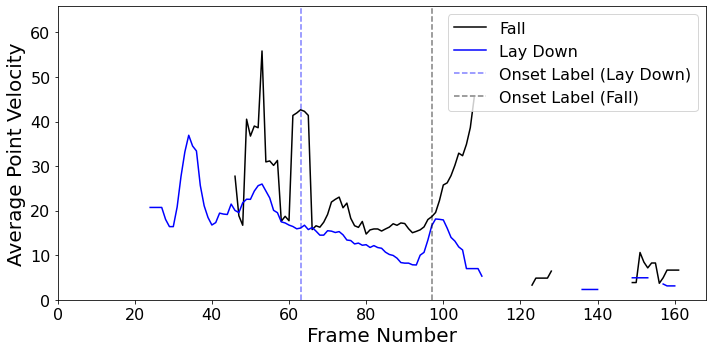

In [ ]:
import matplotlib.pyplot as plt
fs=20
ls = fs-4
t1_ = np.arange(numFrames1)
t2_ = np.arange(numFrames2)

frameAvgDiff1 = getAvgVel(bodyPoints1,kp_thresh = 0.09)
frameAvgDiff2 = getAvgVel(bodyPoints2,kp_thresh = 0.09)

t1,s1 = movAvg(frameAvgDiff1,t1_,winSize=5)
t2,s2 = movAvg(frameAvgDiff2,t2_,winSize=5)

s1_noNone = [v for v in s1 if v != None]
s2_noNone = [v for v in s2 if v != None]

plt.rc('xtick',labelsize=ls)
plt.rc('ytick',labelsize=ls)

plt.figure(figsize=(10,5))
plt.plot(t1,s1,'k',label = 'Fall')
plt.plot(t2,s2,'b',label = 'Lay Down')
plt.ylabel('Average Point Velocity',fontsize = fs)
plt.xlabel('Frame Number',fontsize=fs)
maxNumFrames = max(numFrames1,numFrames2)
plt.xlim([0,maxNumFrames])
plt.ylim([0,np.max([np.max(s1_noNone),np.max(s2_noNone)])+10])
plt.axvline(onsetLabelIdx2,color='b',label='Onset Label (Lay Down)',ls='--',alpha=0.5)
plt.axvline(onsetLabelIdx1,color='k',label='Onset Label (Fall)',ls='--',alpha=0.5)

plt.legend(fontsize=ls)
plt.tight_layout()

sig 164
time 164
out sig 163
out time 163
----
sig 159
time 159
out sig 158
out time 158
----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


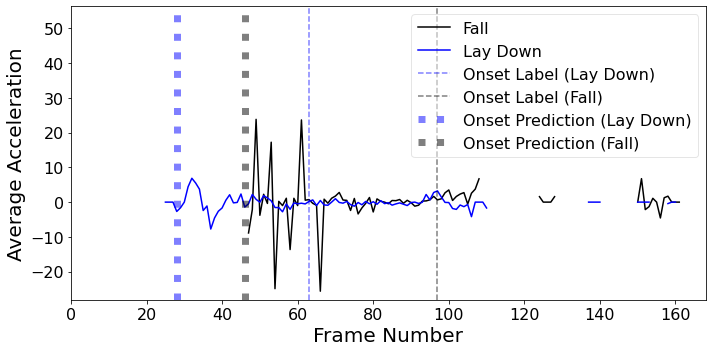

In [ ]:
acc1,t1_ = takeManualDeriv(s1,t1)
print('----')
acc2,t2_ = takeManualDeriv(s2,t2)
print('----')


fs=20
ls = fs-4

idx_1 = getOnsetPrediction(acc1)
idx_2 = getOnsetPrediction(acc2)

# t1_,acc1 = movAvg(acc1,t1_,winSize=1)
# t2_,acc2 = movAvg(acc2,t2_,winSize=1)

s1_noNone = [v for v in acc1 if v != None]
s2_noNone = [v for v in acc2 if v != None]

plt.rc('xtick',labelsize=ls)
plt.rc('ytick',labelsize=ls)

plt.figure(figsize=(10,5))
plt.plot(t1_,acc1,'k',label = 'Fall')
plt.plot(t2_,acc2,'b',label = 'Lay Down')
plt.ylabel('Average Acceleration',fontsize = fs)
plt.xlabel('Frame Number',fontsize=fs)
plt.xlim([0,maxNumFrames])

ylims = plt.axes().get_ylim()
xlims = plt.axes().get_xlim()

plt.ylim([ylims[0],ylims[1]+30])

plt.axvline(onsetLabelIdx2,color='b',label='Onset Label (Lay Down)',ls='--',alpha=0.5)
plt.axvline(onsetLabelIdx1,color='k',label='Onset Label (Fall)',ls='--',alpha=0.5)
plt.axvline(idx_2,color='b',label='Onset Prediction (Lay Down)',ls=':',alpha=0.5,lw=7)
plt.axvline(idx_1,color='k',label='Onset Prediction (Fall)',ls=':',alpha=0.5,lw=7)

plt.legend(fontsize=ls,framealpha=0.5)
plt.tight_layout()



In [ ]:
max = 0
maxIdx = 0
for i in range(1,len(frameAvgDiff1)):
  if frameAvgDiff1[i] != None:
    if frameAvgDiff1[i]>max:
      max = frameAvgDiff1[i]
      maxIdx = i

print(max,maxIdx)

72.54620865141656 121


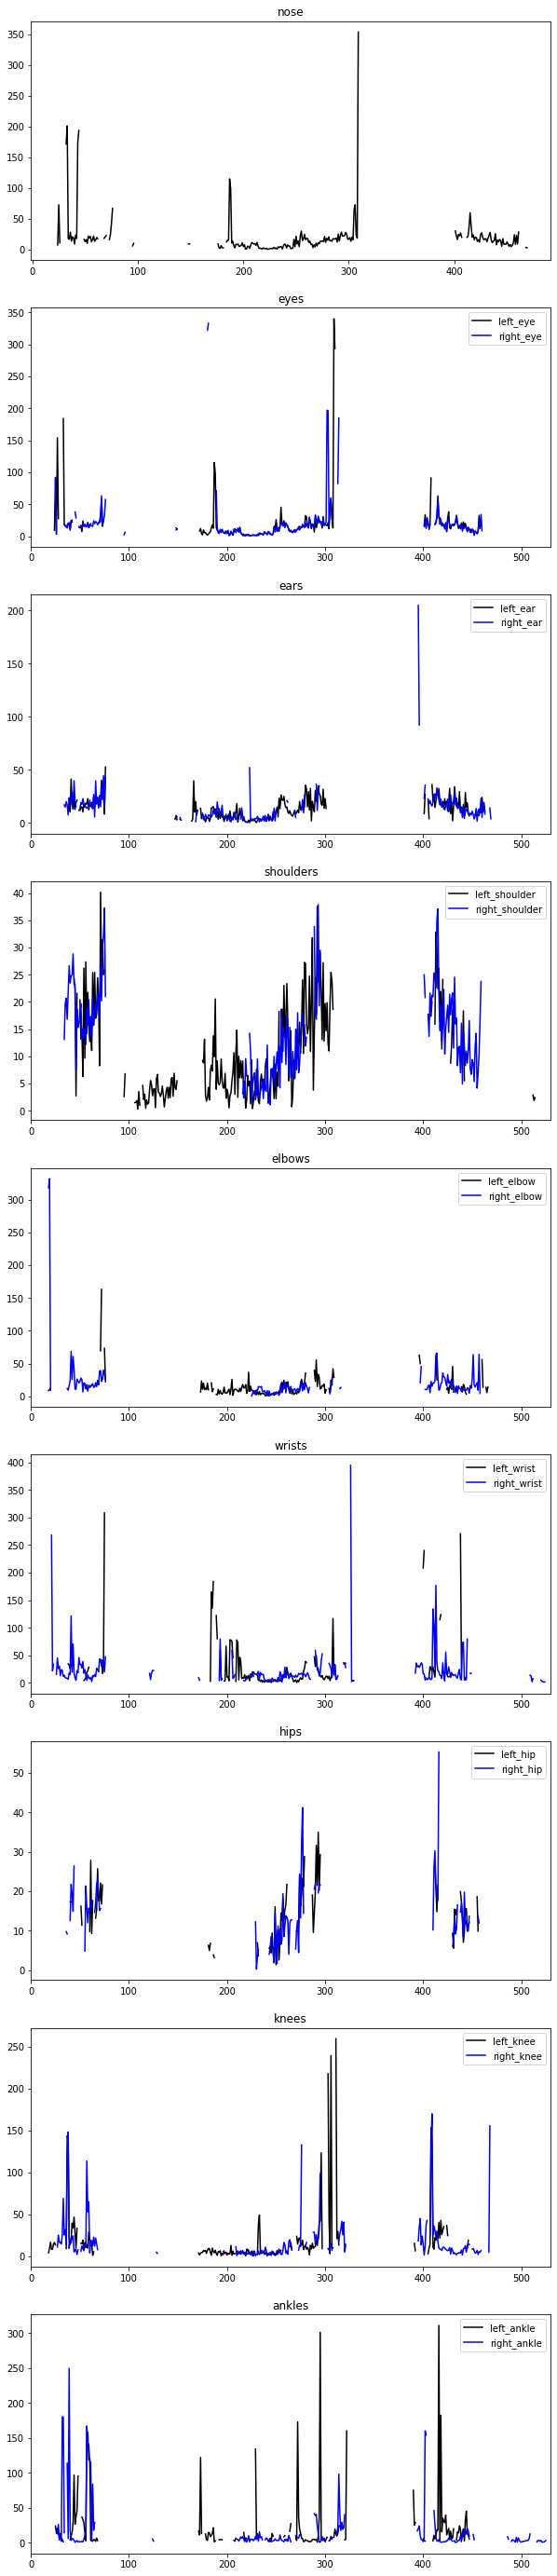

In [ ]:
# bodyPt_colorLabels = {
#     "nose":':k',
#     "left_eye":'-k', "right_eye":'--k',
#     "left_ear":'-c', "right_ear":'--c',
#     "left_shoulder":'-g', "right_shoulder":'--g',
#     "left_elbow":'-r', "right_elbow":'--r',
#     "left_wrist":'-b', "right_wrist":'--b',
#     "left_hip":'-m', "right_hip":'--m',
#     "left_knee":'-p', "right_knee":'--p',
#     "left_ankle":'-r', "right_ankle":'--r',
# }

# fig,axs = plt.subplots(9,1,figsize = (10,50))

# axs[0].plot(keypoint_dict_diff['nose'],'k-',label='nose')
# axs[0].set_title('nose')

# frames = np.arange(numFrames)

# axsCount = 0
# for bodyPt in keypoint_dict_diff:
#   if bodyPt == 'nose':
#     continue

#   if 'left' in bodyPt:
#     axsCount += 1
#     bodyPtName = bodyPt[len('left'):]
#     axs[axsCount].plot(keypoint_dict_diff['left'+bodyPtName],'k-',label=bodyPt)
#     axs[axsCount].set_title(bodyPt[len('left')+1:]+'s')
#     axs[axsCount].plot(keypoint_dict_diff['right'+bodyPtName],'b-',label='right'+bodyPtName)
#     axs[axsCount].legend()
#     axs[axsCount].set_xlim([0,numFrames])

#   if bodyPt == COCO_PERSON_KEYPOINT_NAMES[-1]:
#     break